# 2. Optimisation demostration 

This notebook demostrates basic optimisation functionality. It covers:
- Setting up a PSO optimisation problem
- Defining parameters in the config file
- Running the optimisation with different objective functions implemented in this codebase


You can see more advanced funcionality in the following notebooks:
- `2b_optimisation_extra_functionality.ipynb`: Populaiton weighted objectives, spatial lag, and advanced constraint handling using penalty weights
- `2c_optimisation_multi_swarm.ipynb`: Multi-swarm optimisation



In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from typing import Dict, Any
import logging

# Add src to path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.insert(0, src_path)

print("=== TRANSIT OPTIMIZATION SETUP ===")
print("🚀 Starting self-contained optimization workflow")
print("📊 This notebook will prepare data from scratch and run PSO optimization")


=== TRANSIT OPTIMIZATION SETUP ===
🚀 Starting self-contained optimization workflow
📊 This notebook will prepare data from scratch and run PSO optimization


"""
## 2.1 Data Preparation and Problem Setup

### GTFS Data Loading

First, we'll load the GTFS feed and transform it into optimization data structure.
This replicates the key steps from notebook 1 but focuses only on what's needed for optimization.


In [2]:
from transit_opt.preprocessing.prepare_gtfs import GTFSDataPreparator

print("=== LOADING GTFS DATA ===")

# Create GTFS preparator with same settings as notebook 1
preparator = GTFSDataPreparator(
    gtfs_path='../data/external/study_area_gtfs_bus.zip',
    interval_hours=6,  # 4 periods per day
    date=None,  # Use full GTFS feed
    turnaround_buffer=1.15,  # 15% buffer
    max_round_trip_minutes=240.0,  # Maximum round-trip time
    no_service_threshold_minutes=480.0,  # Threshold for no-service mapping
    log_level="INFO"  # Less verbose than notebook 1
)

# Define allowed headways for optimization
allowed_headways = [10, 15, 30, 60, 120, 240] # in minutes

print(f"📋 Allowed headways: {allowed_headways} minutes")
print("🔄 Extracting optimization data...")

# Extract optimization data structure
opt_data = preparator.extract_optimization_data(allowed_headways)

print(f"\n✅ GTFS DATA PROCESSED:")
print(f"   📊 Routes: {opt_data['n_routes']}")
print(f"   ⏰ Time intervals: {opt_data['n_intervals']} (3h each)")
print(f"   🎯 Decision variables: {opt_data['decision_matrix_shape'][0]} × {opt_data['decision_matrix_shape'][1]} = {np.prod(opt_data['decision_matrix_shape'])}")
print(f"   🚗 Current peak fleet: {opt_data['constraints']['fleet_analysis']['total_current_fleet_peak']} vehicles")
print(f"   🔢 Headway choices: {opt_data['n_choices']} (including no-service)")


2025-10-17 10:15:57,862 - transit_opt.preprocessing.prepare_gtfs - INFO - Initializing GTFSDataPreparator with 6h intervals
2025-10-17 10:15:57,863 - transit_opt.preprocessing.prepare_gtfs - INFO - Loading GTFS feed from ../data/external/study_area_gtfs_bus.zip


=== LOADING GTFS DATA ===


2025-10-17 10:15:59,999 - transit_opt.preprocessing.prepare_gtfs - INFO - Using full GTFS feed (all service periods)
2025-10-17 10:16:01,239 - transit_opt.preprocessing.prepare_gtfs - INFO - GTFS loaded and cached in 3.38 seconds
2025-10-17 10:16:01,239 - transit_opt.preprocessing.prepare_gtfs - INFO - Dataset: 13,974 trips, 703,721 stop times
2025-10-17 10:16:01,240 - transit_opt.preprocessing.prepare_gtfs - INFO - Extracting optimization data with 6 allowed headways
2025-10-17 10:16:01,240 - transit_opt.preprocessing.prepare_gtfs - INFO - Extracting route essentials with 6-hour intervals


📋 Allowed headways: [10, 15, 30, 60, 120, 240] minutes
🔄 Extracting optimization data...


2025-10-17 10:16:02,101 - transit_opt.preprocessing.prepare_gtfs - WARNING - Route 73302: Round-trip 317.4min exceeds limit (240.0min), filtered out
2025-10-17 10:16:02,130 - transit_opt.preprocessing.prepare_gtfs - WARNING - Route 54721: Round-trip 366.8min exceeds limit (240.0min), filtered out
2025-10-17 10:16:03,234 - transit_opt.preprocessing.prepare_gtfs - WARNING - Route 30922: Round-trip 247.2min exceeds limit (240.0min), filtered out
2025-10-17 10:16:03,793 - transit_opt.preprocessing.prepare_gtfs - WARNING - Route 12490: Round-trip 416.3min exceeds limit (240.0min), filtered out
2025-10-17 10:16:03,853 - transit_opt.preprocessing.prepare_gtfs - WARNING - Route 37599: Round-trip 355.3min exceeds limit (240.0min), filtered out
2025-10-17 10:16:05,524 - transit_opt.preprocessing.prepare_gtfs - WARNING - Route 59129: Round-trip 396.7min exceeds limit (240.0min), filtered out
2025-10-17 10:16:08,121 - transit_opt.preprocessing.prepare_gtfs - WARNING - Route 73828: Round-trip 258.8


✅ GTFS DATA PROCESSED:
   📊 Routes: 147
   ⏰ Time intervals: 4 (3h each)
   🎯 Decision variables: 147 × 4 = 588
   🚗 Current peak fleet: 1250 vehicles
   🔢 Headway choices: 7 (including no-service)



### Spatial Boundary Setup

Load the study area boundary for spatial filtering and analysis.
This ensures optimization focuses on the relevant geographic area.


In [3]:
from transit_opt.optimisation.spatial.boundaries import StudyAreaBoundary

print("\n=== SPATIAL BOUNDARY SETUP ===")

# Load boundary geometry
boundary_gdf = gpd.read_file("../data/external/boundaries/study_area_boundary.geojson")
print(f"📍 Loaded boundary with {len(boundary_gdf)} feature(s)")

# Create study area boundary with buffer
study_boundary = StudyAreaBoundary(
    boundary_gdf=boundary_gdf,
    crs="EPSG:3857",  # Web Mercator for spatial analysis
    buffer_km=2.0     # 2km buffer around boundary
)

print(f"✅ Study area boundary created:")
print(f"   📐 CRS: {study_boundary.target_crs}")
print(f"   📏 Buffer: 2km")


=== SPATIAL BOUNDARY SETUP ===
📍 Loaded boundary with 2607 feature(s)
✅ Validated metric CRS: EPSG:3857
🔄 Converting boundary CRS: EPSG:4326 → EPSG:3857
📏 Applied 2.0km buffer
✅ Study area set: 1 polygon(s) in EPSG:3857
✅ Study area boundary created:
   📐 CRS: EPSG:3857
   📏 Buffer: 2km


### Optimization Problem Structure

Before diving into objectives and constraints, let's understand the mathematical structure
of our transit optimization problem.

In [4]:
print("\n=== OPTIMIZATION PROBLEM STRUCTURE ===")
print("🔢 DECISION VARIABLES:")
print(f"   • Each route-interval combination = 1 optimization variable")
print(f"   • Matrix structure: {opt_data['decision_matrix_shape']} (routes × intervals)")
print(f"   • Total variables: {opt_data['decision_matrix_shape'][0] * opt_data['decision_matrix_shape'][1]}")
print(f"   • Each variable chooses from {opt_data['n_choices']} discrete headway options")

print(f"\n🎯 DISCRETE CHOICES:")
print(f"   • Continuous headways (e.g., 17.3 minutes) → Discrete choices (e.g., 15 minutes)")
print(f"   • Algorithms choose indices (0-{opt_data['n_choices']-1}) representing allowed headways")
print(f"   • Variable bounds: {opt_data['variable_bounds']} (choice indices)")

print("\n🕐 ALLOWED HEADWAYS:")
for i, headway in enumerate(opt_data['allowed_headways']):
    if headway >= 9000:
        print(f"   Index {i}: No Service ({headway})")
    else:
        print(f"   Index {i}: {headway:.0f} minutes")

print("\n⏰ TIME STRUCTURE:")
for i, (label, hours) in enumerate(zip(opt_data['intervals']['labels'], opt_data['intervals']['hours'])):
    print(f"   Interval {i}: {label} ({hours[0]:02d}:00-{hours[1]:02d}:00)")



=== OPTIMIZATION PROBLEM STRUCTURE ===
🔢 DECISION VARIABLES:
   • Each route-interval combination = 1 optimization variable
   • Matrix structure: (147, 4) (routes × intervals)
   • Total variables: 588
   • Each variable chooses from 7 discrete headway options

🎯 DISCRETE CHOICES:
   • Continuous headways (e.g., 17.3 minutes) → Discrete choices (e.g., 15 minutes)
   • Algorithms choose indices (0-6) representing allowed headways
   • Variable bounds: (0, 6) (choice indices)

🕐 ALLOWED HEADWAYS:
   Index 0: 10 minutes
   Index 1: 15 minutes
   Index 2: 30 minutes
   Index 3: 60 minutes
   Index 4: 120 minutes
   Index 5: 240 minutes
   Index 6: No Service (9999.0)

⏰ TIME STRUCTURE:
   Interval 0: 00-06h (00:00-06:00)
   Interval 1: 06-12h (06:00-12:00)
   Interval 2: 12-18h (12:00-18:00)
   Interval 3: 18-24h (18:00-24:00)


### Understanding Constraints 

Optimization constraints ensure solutions are operationally feasible:

1. **Fleet Total Constraint**: Limits peak vehicle requirements
2. **Fleet Per-Interval**: Limits vehicles needed in each time period  
3. **Minimum Service**: Ensures minimum service levels are maintained

All constraints work with headway decisions to calculate vehicle requirements.

In [5]:
from transit_opt.optimisation.problems.base import (
    FleetTotalConstraintHandler,
    FleetPerIntervalConstraintHandler, 
    MinimumFleetConstraintHandler
)

print("\n=== CONSTRAINT SYSTEM OVERVIEW ===")
print("Constraints ensure optimization produces deployable solutions:\n")

# Show current fleet analysis
current_fleet = opt_data['constraints']['fleet_analysis']
print("📊 CURRENT FLEET ANALYSIS:")
print(f"   Peak vehicles needed: {current_fleet['total_current_fleet_peak']}")
print(f"   Fleet by interval: {current_fleet['current_fleet_by_interval'].tolist()}")
print(f"   Peak interval: {current_fleet['fleet_stats']['peak_interval']} ({opt_data['intervals']['labels'][current_fleet['fleet_stats']['peak_interval']]})")

print(f"\n🔒 CONSTRAINT EXAMPLES:")

# Fleet Total Constraint
print("1. Fleet Total Constraint:")
print("   • Limits peak vehicles across all time periods")
print("   • Example: ≤ 120% of current peak fleet")
print(f"   • Current peak: {current_fleet['total_current_fleet_peak']} vehicles")
print(f"   • 120% limit: {int(current_fleet['total_current_fleet_peak'] * 1.2)} vehicles")

print("\n2. Fleet Per-Interval Constraint:")
print("   • Limits vehicles needed in each 3-hour period")  
print("   • Prevents unrealistic concentration in one time period")
print("   • Example: ≤ 150% of current interval fleet")

print("\n3. Minimum Fleet Constraint:")
print("   • Ensures minimum service levels are maintained")
print("   • Prevents optimization from eliminating essential routes")
print("   • Example: ≥ 80% of current system-wide service")

# Show service coverage by time interval
print(f"\n📊 CURRENT SERVICE ACTIVITY:")
for i, label in enumerate(opt_data['intervals']['labels']):
    active_routes = np.sum(~np.isnan(opt_data['routes']['current_headways'][:, i]))
    coverage_pct = 100 * active_routes / opt_data['n_routes']
    fleet_needed = current_fleet['current_fleet_by_interval'][i]
    print(f"   {label}: {active_routes}/{opt_data['n_routes']} routes ({coverage_pct:.0f}%), {fleet_needed:.0f} vehicles")




=== CONSTRAINT SYSTEM OVERVIEW ===
Constraints ensure optimization produces deployable solutions:

📊 CURRENT FLEET ANALYSIS:
   Peak vehicles needed: 1250
   Fleet by interval: [575, 1211, 1250, 893]
   Peak interval: 2 (12-18h)

🔒 CONSTRAINT EXAMPLES:
1. Fleet Total Constraint:
   • Limits peak vehicles across all time periods
   • Example: ≤ 120% of current peak fleet
   • Current peak: 1250 vehicles
   • 120% limit: 1500 vehicles

2. Fleet Per-Interval Constraint:
   • Limits vehicles needed in each 3-hour period
   • Prevents unrealistic concentration in one time period
   • Example: ≤ 150% of current interval fleet

3. Minimum Fleet Constraint:
   • Ensures minimum service levels are maintained
   • Prevents optimization from eliminating essential routes
   • Example: ≥ 80% of current system-wide service

📊 CURRENT SERVICE ACTIVITY:
   00-06h: 61/147 routes (41%), 575 vehicles
   06-12h: 145/147 routes (99%), 1211 vehicles
   12-18h: 143/147 routes (97%), 1250 vehicles
   18-24h:

### Objective Functions

Transit network optimization can be based on various objectives. User objectives and operator objectives tend to be at odds. In our implementation, we focus only on user objectives, and replace operator objectives with constraints on fleet size. The user objectives we implement are:

- **Minimising Variance in stop distribution**: This objective aims to ensure that transit stops are evenly distributed across the service area. It is a simple proxy for accessibility that avoids reliance on routing.
- **Minimising user waiting time**: This objective aims to reduce the average / overall waiting time for users at transit stops. It is calculated based on the headways of routes serving stops in each zone
- **Minimising user travel time**: TODO (see https://github.com/Hussein-Mahfouz/transit_opt/issues/1)

All objectives are based on zone level statistics, which are then aggregated to the system level


#### Objective 1: Variance in stop distribution

The `HexagonalCoverageObjective` works by calculating the variance in buses per zone

• Divides study area into hexagonal zones of equal size
• Calculates vehicle service per zone based on route headways
• Minimizes variance in service distribution across zones

##### Applying objective to current system

In [6]:
# =============================================================================
# SECTION 1: HEXAGONAL COVERAGE OBJECTIVE (SPATIAL EQUITY)
# =============================================================================

print("\n" + "="*80)
print("🎯 OBJECTIVE: HEXAGONAL COVERAGE OBJECTIVE")
print("="*80)

from transit_opt.optimisation.objectives import HexagonalCoverageObjective

print("\n🔧 COVERAGE OBJECTIVE SETUP:")
# Create coverage objective with explicit parameter values
coverage_objective = HexagonalCoverageObjective(
    optimization_data=opt_data,
    spatial_resolution_km=2.0,      # 3km diameter hexagons
    crs="EPSG:3857",                # Web Mercator (metric CRS)
    boundary=study_boundary,        # Filter to study area only
    time_aggregation="average",     # Average service across time intervals
    spatial_lag=False             # Standard variance (no neighbor effects)
    )

print(f"   ✅ Hexagonal zones created: {len(coverage_objective.spatial_system.hex_grid)}")
print(f"   ✅ Transit stops included: {len(coverage_objective.spatial_system.stops_gdf)}")

print("\n📊 BASELINE COVERAGE PERFORMANCE:")
current_coverage_value = coverage_objective.evaluate(opt_data['initial_solution'])
coverage_analysis = coverage_objective.get_detailed_analysis(opt_data['initial_solution'])

print(f"   Objective value (variance): {current_coverage_value:.6f}")
print(f"   Zones with service: {coverage_analysis['zones_with_service_average']}/{len(coverage_objective.spatial_system.hex_grid)} ({coverage_analysis['zones_with_service_average']/len(coverage_objective.spatial_system.hex_grid)*100:.1f}%)")
print(f"   Mean vehicles per zone: {coverage_analysis['total_vehicles_average']:.2f}")
print(f"   Standard deviation: {coverage_analysis['std_dev_average']:.3f}")
print(f"   Coefficient of variation: {coverage_analysis['coefficient_of_variation_average']:.3f}")

print("\n💡 INTERPRETATION:")
print(f"   • Lower variance = more equitable service distribution")
print(f"   • {coverage_analysis['zones_without_service']} zones currently have no transit service")
print(f"   • CV of {coverage_analysis['coefficient_of_variation_average']:.3f} indicates {'high' if coverage_analysis['coefficient_of_variation_average'] > 1.0 else 'moderate'} service inequality")
print(f"   • This objective will try to redistribute service more evenly")



🎯 OBJECTIVE: HEXAGONAL COVERAGE OBJECTIVE

🔧 COVERAGE OBJECTIVE SETUP:
🗺️ Setting up spatial analysis with 2.0km resolution
🗺️  Reprojected 6897 stops to EPSG:3857
🎯 Applying boundary filter to 6897 stops...
🔍 Filtered 6897 → 4405 points
✅ Filtered to 4405 stops within boundary
🔧 Creating 27 × 26 = 702 grid cells
   Grid bounds: (-195346, 7111759) to (-142657, 7161976) meters
   Cell size: 2000.0m × 2000.0m
✅ Created 702 hexagonal zones in EPSG:3857
🎯 Applying boundary filter to 702 grid cells...
🔍 Filtered 702 → 552 grid cells
✅ Filtered to 552 grid cells within boundary
🚀 Using spatial join for zone mapping...
✅ Mapped 4405 stops to zones
🚀 Pre-computing route-stop mappings...
✅ Cached stops for 187 routes
✅ Spatial system ready: 552 hexagonal zones
   ✅ Hexagonal zones created: 552
   ✅ Transit stops included: 4405

📊 BASELINE COVERAGE PERFORMANCE:
📊 Vehicles per zone (average): min=0.0, max=650.75, var=3325.22
   Objective value (variance): 3325.215462
   Zones with service: 347/5

##### Running PSO optimisation with HexagonalCoverageObjective

In [7]:

print("\n🚀 RUNNING COVERAGE OPTIMIZATION...")

# Configuration for Coverage Objective
config_coverage = {
    'problem': {
        'objective': {
            'type': 'HexagonalCoverageObjective',
            'spatial_resolution_km': 2.0,
            'crs': 'EPSG:3857',
            'boundary': study_boundary,
            'boundary_buffer_km': 2.0,
            'time_aggregation': 'average'
        },
        'constraints': [
            {
                'type': 'FleetTotalConstraintHandler',
                'baseline': 'current_peak',
                'tolerance': 0.35,  # if value = 0.35 then 35% increase allowed
                'measure': 'peak'
            },
            {
                'type': 'MinimumFleetConstraintHandler',
                'min_fleet_fraction': 0.95,  # if value = 0.80, maintain at least 80% of current service
                'level': 'system',
                'measure': 'peak', 
                'baseline': 'current_peak'
            }
        ]
    },
    'optimization': {
        'algorithm': {
            'type': 'PSO',
            'pop_size': 35,
            'inertia_weight': 0.9,
            'inertia_weight_final': 0.4,
            'cognitive_coeff': 2.0,
            'social_coeff': 2.0,
            'use_penalty_method': False
        },
        'termination': {'max_generations': 50},
        'monitoring': {'progress_frequency': 5, 'save_history': True}
    }
}

from transit_opt.optimisation.config.config_manager import OptimizationConfigManager
from transit_opt.optimisation.runners.pso_runner import PSORunner

print(f"   Algorithm: PSO with {config_coverage['optimization']['algorithm']['pop_size']} particles")
print(f"   Generations: {config_coverage['optimization']['termination']['max_generations']}")

config_manager_coverage = OptimizationConfigManager(config_dict=config_coverage)
pso_runner_coverage = PSORunner(config_manager_coverage)
result_coverage = pso_runner_coverage.optimize(opt_data, track_best_n=5)

print(f"\n✅ COVERAGE OPTIMIZATION RESULTS:")
print(f"   Runtime: {result_coverage.optimization_time:.1f} seconds")
print(f"   Generations completed: {result_coverage.generations_completed}")
print(f"   Best objective: {result_coverage.best_objective:.6f}")
print(f"   Improvement: {((current_coverage_value - result_coverage.best_objective) / current_coverage_value * 100):+.1f}%")
print(f"   Feasible solution: {'✅ Yes' if result_coverage.constraint_violations['feasible'] else '❌ No'}")

if not result_coverage.constraint_violations['feasible']:
    print("   ⚠️ Constraint violations:")
    for detail in result_coverage.constraint_violations['violation_details']:
        if detail['violation'] < -0.001:
            print(f"      • Constraint {detail['constraint_idx']}: {detail['violation']:.3f}")

# Analyze optimized solution
optimized_coverage_analysis = coverage_objective.get_detailed_analysis(result_coverage.best_solution)

print(f"\n📈 COVERAGE SOLUTION ANALYSIS:")
print(f"   Zones with service: {coverage_analysis['zones_with_service_average']} → {optimized_coverage_analysis['zones_with_service_average']} ({optimized_coverage_analysis['zones_with_service_average'] - coverage_analysis['zones_with_service_average']:+.0f})")
print(f"   Mean vehicles/zone: {coverage_analysis['total_vehicles_average']:.2f} → {optimized_coverage_analysis['total_vehicles_average']:.2f} ({((optimized_coverage_analysis['total_vehicles_average'] - coverage_analysis['total_vehicles_average']) / coverage_analysis['total_vehicles_average'] * 100):+.1f}%)")
print(f"   Service variance: {coverage_analysis['variance_average']:.6f} → {optimized_coverage_analysis['variance_average']:.6f} ({((optimized_coverage_analysis['variance_average'] - coverage_analysis['variance_average']) / coverage_analysis['variance_average'] * 100):+.1f}%)")
print(f"   Coefficient of variation: {coverage_analysis['coefficient_of_variation_average']:.3f} → {optimized_coverage_analysis['coefficient_of_variation_average']:.3f}")

print(f"\n✅ Coverage objective analysis complete!")


🚀 RUNNING COVERAGE OPTIMIZATION...
   Algorithm: PSO with 35 particles
   Generations: 50
📋 Using provided configuration dictionary
🚀 STARTING PSO OPTIMIZATION
🗺️ Setting up spatial analysis with 2.0km resolution
🗺️  Reprojected 6897 stops to EPSG:3857
🎯 Applying boundary filter to 6897 stops...
🔍 Filtered 6897 → 4405 points
✅ Filtered to 4405 stops within boundary
🔧 Creating 27 × 26 = 702 grid cells
   Grid bounds: (-195346, 7111759) to (-142657, 7161976) meters
   Cell size: 2000.0m × 2000.0m
✅ Created 702 hexagonal zones in EPSG:3857
🎯 Applying boundary filter to 702 grid cells...
🔍 Filtered 702 → 552 grid cells
✅ Filtered to 552 grid cells within boundary
🚀 Using spatial join for zone mapping...
✅ Mapped 4405 stops to zones
🚀 Pre-computing route-stop mappings...
✅ Cached stops for 187 routes
✅ Spatial system ready: 552 hexagonal zones
   📋 Creating 2 constraint handler(s)...
      Creating constraint 1: FleetTotalConstraintHandler
         ✓ FleetTotal: 1 constraint(s)
      Creat

#### Objective 2: User waiting time

The `WaitingTimeObjective` works by calculating the average / total waiting time for users at stops in each zone, based on the headways of routes serving those stops.
In the config we can specify:

- `metric`: this can be "total" or "variance".
    - "total": Minimize total waiting time across all zones 
    - "variance": Minimize variance in waiting times between zones 

- `time_aggregation`: how the waiting times are combined across time intervals
    - "average": Average waiting times across all time intervals
    - "peak": Use waiting times from the system-wide peak interval (interval with most total vehicles)
    - "sum": Sum waiting times across all intervals
    - "intervals": Calculate objective for each interval separately, then average the results

All 16 combinations (4 × 4) are technically permitted, but not all make sense: 

- Combinations That Make Sense

    - metric="total" (Minimize total waiting time):
        - time_aggregation="average" - Minimize average total waiting across time periods
        - time_aggregation="sum" - Minimize cumulative waiting time across all periods
        - time_aggregation="peak" - Minimize total waiting during peak period
        - time_aggregation="intervals" - Minimize average of interval totals
    - metric="variance" (Minimize inequality between zones):
        - time_aggregation="average" - Minimize inequality in average waiting times
        - time_aggregation="peak" - Minimize inequality during peak period
        - time_aggregation="intervals" - Minimize average of interval variances (makes sense but complex)

- Problematic Combination
      - metric="variance" + time_aggregation="sum" - For each zone, sums waiting time across all intervals, then calculates variance of these sums across zones. This mixes temporal aggregation (sum) with spatial equity (variance) in a confusing way


##### Applying objective to current system

In [8]:
# =============================================================================
# SECTION 2: WAITING TIME OBJECTIVE (USER EXPERIENCE)
# =============================================================================

print("\n" + "="*80)
print("🕐 SECTION 2: WAITING TIME OBJECTIVE (USER EXPERIENCE)")
print("="*80)

from transit_opt.optimisation.objectives.waiting_time import WaitingTimeObjective


print("\n🔧 WAITING TIME OBJECTIVE SETUP:")
# Create waiting time objective with explicit parameter values
waiting_objective = WaitingTimeObjective(
    optimization_data=opt_data,
    spatial_resolution_km=2.0,      # Same zone size as coverage objective
    boundary=study_boundary,        # Same study area
    metric="variance",                 # Minimize variance in waiting time across zones
    crs="EPSG:3857",                # Web Mercator (metric CRS)
    time_aggregation="average",     # Average across time intervals
    population_weighted=False,      # No population weighting (simple version)
)

print(f"   ✅ Hexagonal zones created: {len(waiting_objective.spatial_system.hex_grid)}")
print(f"   ✅ Transit stops included: {len(waiting_objective.spatial_system.stops_gdf)}")
print(f"   ✅ Optimization metric: {waiting_objective.metric} waiting time")
print(f"   ✅ Time aggregation: {waiting_objective.time_aggregation}")
print(f"   ✅ Population weighting: {'Enabled' if False else 'Disabled'}")

print("\n📊 BASELINE WAITING TIME PERFORMANCE:")
current_waiting_value = waiting_objective.evaluate(opt_data['initial_solution'])

# Calculate zone-level statistics for interpretation
vehicles_data = waiting_objective.spatial_system._vehicles_per_zone(
    opt_data['initial_solution'], opt_data
)
zones_with_service = np.sum(vehicles_data['average'] > 0)
total_zones = len(vehicles_data['average'])

print(f"   Objective value: {current_waiting_value:.2f} minutes")
print(f"   Zones with service: {zones_with_service}/{total_zones} ({zones_with_service/total_zones*100:.1f}%)")
print(f"   Zones without service: {total_zones - zones_with_service}")
print(f"   Mean vehicles per zone: {np.mean(vehicles_data['average']):.2f}")



🕐 SECTION 2: WAITING TIME OBJECTIVE (USER EXPERIENCE)

🔧 WAITING TIME OBJECTIVE SETUP:
🗺️ Setting up spatial analysis with 2.0km resolution
🗺️  Reprojected 6897 stops to EPSG:3857
🎯 Applying boundary filter to 6897 stops...
🔍 Filtered 6897 → 4405 points
✅ Filtered to 4405 stops within boundary
🔧 Creating 27 × 26 = 702 grid cells
   Grid bounds: (-195346, 7111759) to (-142657, 7161976) meters
   Cell size: 2000.0m × 2000.0m
✅ Created 702 hexagonal zones in EPSG:3857
🎯 Applying boundary filter to 702 grid cells...
🔍 Filtered 702 → 552 grid cells
✅ Filtered to 552 grid cells within boundary
🚀 Using spatial join for zone mapping...
✅ Mapped 4405 stops to zones
🚀 Pre-computing route-stop mappings...
✅ Cached stops for 187 routes
✅ Spatial system ready: 552 hexagonal zones, metric: variance, time aggregation: average
   ✅ Hexagonal zones created: 552
   ✅ Transit stops included: 4405
   ✅ Optimization metric: variance waiting time
   ✅ Time aggregation: average
   ✅ Population weighting: Di

Note that the objective value is very high. This is because we have many zones with no service. In the current implementation, zones with no service are assigned a waiting time equal to the interval length (e.g. if a day is split into 4 intervals of 6 hours, then zones with no service are assigned a waiting time of 360 minutes). 

TODO: It may be useful to add an option to ignore zones with no service when calculating the objective value.

In [9]:
# Debug the actual waiting time calculation
print("\n🔍 Showing WAITING TIME CALCULATION:")

# Get vehicle data
vehicles_data = waiting_objective.spatial_system._vehicles_per_zone(
    opt_data['initial_solution'], opt_data
)

# Check how many zones have no service
zones_with_service = np.sum(vehicles_data['average'] > 0)
zones_without_service = len(vehicles_data['average']) - zones_with_service
interval_length = waiting_objective._get_interval_length_minutes()

print(f"   Total zones: {len(vehicles_data['average'])}")
print(f"   Zones with service: {zones_with_service}")
print(f"   Zones without service: {zones_without_service}")
print(f"   Interval length: {interval_length} minutes")
print(f"   No-service penalty per zone: {interval_length} minutes")
print(f"   Total penalty from no-service zones: {zones_without_service * interval_length} minutes")

# Calculate actual waiting times for first few zones
print(f"\n   Sample vehicle counts and waiting times:")
for i in range(min(10, len(vehicles_data['average']))):
    vehicle_count = vehicles_data['average'][i]
    waiting_time = waiting_objective._convert_vehicle_count_to_waiting_time(
        vehicle_count, interval_length
    )
    print(f"     Zone {i}: {vehicle_count:.2f} vehicles → {waiting_time:.1f} min waiting")


🔍 Showing WAITING TIME CALCULATION:
⏱️ Interval length: 360 minutes (cached)
   Total zones: 552
   Zones with service: 347
   Zones without service: 205
   Interval length: 360.0 minutes
   No-service penalty per zone: 360.0 minutes
   Total penalty from no-service zones: 73800.0 minutes

   Sample vehicle counts and waiting times:
     Zone 0: 15.75 vehicles → 11.4 min waiting
     Zone 1: 0.00 vehicles → 360.0 min waiting
     Zone 2: 0.00 vehicles → 360.0 min waiting
     Zone 3: 28.25 vehicles → 6.4 min waiting
     Zone 4: 2.00 vehicles → 90.0 min waiting
     Zone 5: 14.75 vehicles → 12.2 min waiting
     Zone 6: 0.00 vehicles → 360.0 min waiting
     Zone 7: 0.00 vehicles → 360.0 min waiting
     Zone 8: 13.25 vehicles → 13.6 min waiting
     Zone 9: 16.50 vehicles → 10.9 min waiting


##### Running PSO with WaitingTimeObjective (objective = minimise VARIANCE in waiting time)

In [10]:

print("\n🚀 RUNNING WAITING TIME OPTIMIZATION...")

# Configuration for Waiting Time Objective  
config_waiting = {
    'problem': {
        'objective': {
            'type': 'WaitingTimeObjective',
            'spatial_resolution_km': 2.0,
            'boundary': study_boundary,
            'boundary_buffer_km': 2.0,
            'metric': 'variance',
            'time_aggregation': 'average',
            'population_weighted': False
        },
        'constraints': [
            {
                'type': 'FleetTotalConstraintHandler',
                'baseline': 'current_peak',
                'tolerance': 0.35,  # 35% increase allowed
                'measure': 'peak'
            },
            {
                'type': 'MinimumFleetConstraintHandler',
                'min_fleet_fraction': 0.95,  # Maintain X% of current service
                'level': 'system',
                'measure': 'peak', 
                'baseline': 'current_peak'
            }
        ]
    },
    'optimization': {
        'algorithm': {
            'type': 'PSO',
            'pop_size': 30,
            'inertia_weight': 0.9,
            'inertia_weight_final': 0.4,
            'cognitive_coeff': 2.0,
            'social_coeff': 2.0,
            'use_penalty_method': False
        },
        'termination': {'max_generations': 50},
        'monitoring': {'progress_frequency': 5, 'save_history': True}
    }
}

print("   Goal: Minimize variance in passenger waiting time")
print(f"   Algorithm: PSO with {config_waiting['optimization']['algorithm']['pop_size']} particles")
print(f"   Generations: {config_waiting['optimization']['termination']['max_generations']}")

config_manager_waiting = OptimizationConfigManager(config_dict=config_waiting)
pso_runner_waiting = PSORunner(config_manager_waiting)
result_waiting = pso_runner_waiting.optimize(opt_data, track_best_n=5)

print(f"\n✅ WAITING TIME OPTIMIZATION RESULTS:")
print(f"   Runtime: {result_waiting.optimization_time:.1f} seconds")
print(f"   Generations completed: {result_waiting.generations_completed}")
print(f"   Best objective: {result_waiting.best_objective:.2f} minutes")
print(f"   Improvement: {((current_waiting_value - result_waiting.best_objective) / current_waiting_value * 100):+.1f}%")
print(f"   Feasible solution: {'✅ Yes' if result_waiting.constraint_violations['feasible'] else '❌ No'}")

if not result_waiting.constraint_violations['feasible']:
    print("   ⚠️ Constraint violations:")
    for detail in result_waiting.constraint_violations['violation_details']:
        if detail['violation'] < -0.001:
            print(f"      • Constraint {detail['constraint_idx']}: {detail['violation']:.3f}")

# Analyze optimized solution
optimized_vehicles_data = waiting_objective.spatial_system._vehicles_per_zone(
    result_waiting.best_solution, opt_data
)
optimized_zones_with_service = np.sum(optimized_vehicles_data['average'] > 0)

print(f"\n📈 WAITING TIME SOLUTION ANALYSIS:")
print(f"   Variance in waiting time: {current_waiting_value:.2f} → {result_waiting.best_objective:.2f} minutes ({((result_waiting.best_objective - current_waiting_value) / current_waiting_value * 100):+.1f}%)")
print(f"   Zones with service: {zones_with_service} → {optimized_zones_with_service} ({optimized_zones_with_service - zones_with_service:+.0f})")
print(f"   Mean vehicles/zone: {np.mean(vehicles_data['average']):.2f} → {np.mean(optimized_vehicles_data['average']):.2f} ({((np.mean(optimized_vehicles_data['average']) - np.mean(vehicles_data['average'])) / np.mean(vehicles_data['average']) * 100):+.1f}%)")

print(f"\n✅ Waiting time objective analysis complete!")


🚀 RUNNING WAITING TIME OPTIMIZATION...
   Goal: Minimize variance in passenger waiting time
   Algorithm: PSO with 30 particles
   Generations: 50
📋 Using provided configuration dictionary
🚀 STARTING PSO OPTIMIZATION
🗺️ Setting up spatial analysis with 2.0km resolution
🗺️  Reprojected 6897 stops to EPSG:3857
🎯 Applying boundary filter to 6897 stops...
🔍 Filtered 6897 → 4405 points
✅ Filtered to 4405 stops within boundary
🔧 Creating 27 × 26 = 702 grid cells
   Grid bounds: (-195346, 7111759) to (-142657, 7161976) meters
   Cell size: 2000.0m × 2000.0m
✅ Created 702 hexagonal zones in EPSG:3857
🎯 Applying boundary filter to 702 grid cells...
🔍 Filtered 702 → 552 grid cells
✅ Filtered to 552 grid cells within boundary
🚀 Using spatial join for zone mapping...
✅ Mapped 4405 stops to zones
🚀 Pre-computing route-stop mappings...
✅ Cached stops for 187 routes
✅ Spatial system ready: 552 hexagonal zones, metric: variance, time aggregation: average
   📋 Creating 2 constraint handler(s)...
     

##### Running PSO with WaitingTimeObjective (objective = minimise TOTAL waiting time)

In [11]:
# =============================================================================
# SECTION 2B: WAITING TIME OBJECTIVE (TOTAL) 
# =============================================================================

print("\n" + "="*80)
print("🕐 SECTION 2B: WAITING TIME OBJECTIVE (TOTAL) - USER EXPERIENCE")
print("="*80)

from transit_opt.optimisation.objectives.waiting_time import WaitingTimeObjective

print("\n🔧 WAITING TIME OBJECTIVE SETUP (TOTAL):")
# Create waiting time objective with metric="total"
waiting_objective_total = WaitingTimeObjective(
    optimization_data=opt_data,
    spatial_resolution_km=2.0,      # Same zone size as coverage objective
    boundary=study_boundary,        # Same study area
    metric="total",                 # Minimize TOTAL waiting time across zones
    crs="EPSG:3857",                # Web Mercator (metric CRS)
    time_aggregation="average",     # Average across time intervals
    population_weighted=False,      # No population weighting (simple version)
)

print(f"   ✅ Hexagonal zones created: {len(waiting_objective_total.spatial_system.hex_grid)}")
print(f"   ✅ Transit stops included: {len(waiting_objective_total.spatial_system.stops_gdf)}")
print(f"   ✅ Optimization metric: {waiting_objective_total.metric} waiting time")
print(f"   ✅ Time aggregation: {waiting_objective_total.time_aggregation}")
print(f"   ✅ Population weighting: {'Enabled' if waiting_objective_total.population_weighted else 'Disabled'}")

print("\n📊 BASELINE WAITING TIME PERFORMANCE (TOTAL):")
current_waiting_value_total = waiting_objective_total.evaluate(opt_data['initial_solution'])

# Calculate zone-level statistics for interpretation
vehicles_data_total = waiting_objective_total.spatial_system._vehicles_per_zone(
    opt_data['initial_solution'], opt_data
)
zones_with_service_total = np.sum(vehicles_data_total['average'] > 0)
total_zones_count = len(vehicles_data_total['average'])

print(f"   Objective value (total waiting time): {current_waiting_value_total:.2f} minutes")
print(f"   Zones with service: {zones_with_service_total}/{total_zones_count} ({zones_with_service_total/total_zones_count*100:.1f}%)")
print(f"   Zones without service: {total_zones_count - zones_with_service_total}")
print(f"   Mean vehicles per zone: {np.mean(vehicles_data_total['average']):.2f}")



🕐 SECTION 2B: WAITING TIME OBJECTIVE (TOTAL) - USER EXPERIENCE

🔧 WAITING TIME OBJECTIVE SETUP (TOTAL):
🗺️ Setting up spatial analysis with 2.0km resolution
🗺️  Reprojected 6897 stops to EPSG:3857
🎯 Applying boundary filter to 6897 stops...
🔍 Filtered 6897 → 4405 points
✅ Filtered to 4405 stops within boundary
🔧 Creating 27 × 26 = 702 grid cells
   Grid bounds: (-195346, 7111759) to (-142657, 7161976) meters
   Cell size: 2000.0m × 2000.0m
✅ Created 702 hexagonal zones in EPSG:3857
🎯 Applying boundary filter to 702 grid cells...
🔍 Filtered 702 → 552 grid cells
✅ Filtered to 552 grid cells within boundary
🚀 Using spatial join for zone mapping...
✅ Mapped 4405 stops to zones
🚀 Pre-computing route-stop mappings...
✅ Cached stops for 187 routes
✅ Spatial system ready: 552 hexagonal zones, metric: total, time aggregation: average
   ✅ Hexagonal zones created: 552
   ✅ Transit stops included: 4405
   ✅ Optimization metric: total waiting time
   ✅ Time aggregation: average
   ✅ Population we

In [12]:

print("\n🚀 RUNNING WAITING TIME OPTIMIZATION (TOTAL)...")

# Configuration for Waiting Time Objective (TOTAL)
config_waiting_total = {
    'problem': {
        'objective': {
            'type': 'WaitingTimeObjective',
            'spatial_resolution_km': 2.0,
            'boundary': study_boundary,
            'boundary_buffer_km': 2.0,
            'metric': 'total',              # TOTAL waiting time
            'time_aggregation': 'average',
            'population_weighted': False
        },
        'constraints': [
            {
                'type': 'FleetTotalConstraintHandler',
                'baseline': 'current_peak',
                'tolerance': 0.35,  # 35% increase allowed
                'measure': 'peak'
            },
            {
                'type': 'MinimumFleetConstraintHandler',
                'min_fleet_fraction': 0.95,  # Maintain 70% of current service
                'level': 'system',
                'measure': 'peak', 
                'baseline': 'current_peak'
            }
        ]
    },
    'optimization': {
        'algorithm': {
            'type': 'PSO',
            'pop_size': 35,
            'inertia_weight': 0.9,
            'inertia_weight_final': 0.4,
            'cognitive_coeff': 2.0,
            'social_coeff': 2.0,
            'use_penalty_method': False
        },
        'termination': {'max_generations': 50},
        'monitoring': {'progress_frequency': 5, 'save_history': True}
    }
}

print("   Goal: Minimize TOTAL passenger waiting time across all zones")
print(f"   Algorithm: PSO with {config_waiting_total['optimization']['algorithm']['pop_size']} particles")
print(f"   Generations: {config_waiting_total['optimization']['termination']['max_generations']}")

config_manager_waiting_total = OptimizationConfigManager(config_dict=config_waiting_total)
pso_runner_waiting_total = PSORunner(config_manager_waiting_total)
result_waiting_total = pso_runner_waiting_total.optimize(opt_data, track_best_n=5)

print(f"\n✅ WAITING TIME OPTIMIZATION RESULTS (TOTAL):")
print(f"   Runtime: {result_waiting_total.optimization_time:.1f} seconds")
print(f"   Generations completed: {result_waiting_total.generations_completed}")
print(f"   Best objective: {result_waiting_total.best_objective:.2f} minutes")
print(f"   Improvement: {((current_waiting_value_total - result_waiting_total.best_objective) / current_waiting_value_total * 100):+.1f}%")
print(f"   Feasible solution: {'✅ Yes' if result_waiting_total.constraint_violations['feasible'] else '❌ No'}")

if not result_waiting_total.constraint_violations['feasible']:
    print("   ⚠️ Constraint violations:")
    for detail in result_waiting_total.constraint_violations['violation_details']:
        if detail['violation'] < -0.001:
            print(f"      • Constraint {detail['constraint_idx']}: {detail['violation']:.3f}")

# Analyze optimized solution
optimized_vehicles_data_total = waiting_objective_total.spatial_system._vehicles_per_zone(
    result_waiting_total.best_solution, opt_data
)
optimized_zones_with_service_total = np.sum(optimized_vehicles_data_total['average'] > 0)

print(f"\n📈 WAITING TIME SOLUTION ANALYSIS (TOTAL):")
print(f"   Total waiting time: {current_waiting_value_total:.2f} → {result_waiting_total.best_objective:.2f} minutes ({((result_waiting_total.best_objective - current_waiting_value_total) / current_waiting_value_total * 100):+.1f}%)")
print(f"   Zones with service: {zones_with_service_total} → {optimized_zones_with_service_total} ({optimized_zones_with_service_total - zones_with_service_total:+.0f})")
print(f"   Mean vehicles/zone: {np.mean(vehicles_data_total['average']):.2f} → {np.mean(optimized_vehicles_data_total['average']):.2f} ({((np.mean(optimized_vehicles_data_total['average']) - np.mean(vehicles_data_total['average'])) / np.mean(vehicles_data_total['average']) * 100):+.1f}%)")

print(f"\n✅ Waiting time objective (TOTAL) analysis complete!")


🚀 RUNNING WAITING TIME OPTIMIZATION (TOTAL)...
   Goal: Minimize TOTAL passenger waiting time across all zones
   Algorithm: PSO with 35 particles
   Generations: 50
📋 Using provided configuration dictionary
🚀 STARTING PSO OPTIMIZATION
🗺️ Setting up spatial analysis with 2.0km resolution
🗺️  Reprojected 6897 stops to EPSG:3857
🎯 Applying boundary filter to 6897 stops...
🔍 Filtered 6897 → 4405 points
✅ Filtered to 4405 stops within boundary
🔧 Creating 27 × 26 = 702 grid cells
   Grid bounds: (-195346, 7111759) to (-142657, 7161976) meters
   Cell size: 2000.0m × 2000.0m
✅ Created 702 hexagonal zones in EPSG:3857
🎯 Applying boundary filter to 702 grid cells...
🔍 Filtered 702 → 552 grid cells
✅ Filtered to 552 grid cells within boundary
🚀 Using spatial join for zone mapping...
✅ Mapped 4405 stops to zones
🚀 Pre-computing route-stop mappings...
✅ Cached stops for 187 routes
✅ Spatial system ready: 552 hexagonal zones, metric: total, time aggregation: average
   📋 Creating 2 constraint han

### Comparing results from different objectives

Lets compare:
- HexagonalCoverageObjective (minimising variance in stop distribution)
- WaitingTimeObjective (minimising variance in waiting time)
- WaitingTimeObjective (minimising total waiting time)

In [13]:
# =============================================================================
# SECTION 3: CROSS-OBJECTIVE COMPARISON 
# =============================================================================

print("\n" + "="*80)
print("🔄 SECTION 3: CROSS-OBJECTIVE COMPARISON AND ANALYSIS")
print("="*80)

print("\n📊 SUMMARY OF ALL OPTIMIZATION RUNS:")

# Store all results for easy comparison
# This dictionary organizes results from three different optimization objectives:
# 1. Coverage (Equity) - minimizes variance in vehicle distribution across zones
# 2. Waiting (Variance) - minimizes inequality in waiting times between zones  
# 3. Waiting (Total) - minimizes total waiting time across all zones
all_results = {
    'coverage': {
        'name': 'Coverage (Equity)',
        'objective_func': coverage_objective,           # The objective function instance
        'result': result_coverage,                      # OptimizationResult from PSO
        'baseline': current_coverage_value,             # Original system performance
        'optimized': result_coverage.best_objective,    # Best solution found
        'units': 'variance',                            # Units for display formatting
        'description': 'Minimize variance in vehicle distribution'
    },
    'waiting_variance': {
        'name': 'Waiting (Variance)',
        'objective_func': waiting_objective,
        'result': result_waiting,
        'baseline': current_waiting_value,              # ~21,895 minutes² (variance)
        'optimized': result_waiting.best_objective,
        'units': 'minutes²',                            # Variance has squared units
        'description': 'Minimize variance in waiting times'
    },
    'waiting_total': {
        'name': 'Waiting (Total)',
        'objective_func': waiting_objective_total,
        'result': result_waiting_total,
        'baseline': current_waiting_value_total,        # ~13.5M minutes (huge due to no-service zones)
        'optimized': result_waiting_total.best_objective,
        'units': 'minutes',                             # Simple time units
        'description': 'Minimize total waiting time'
    }
}

# Print comparison table
# This shows how each optimization objective performed relative to the baseline
print(f"{'Objective':<18} {'Baseline':<15} {'Optimized':<15} {'Improvement':<12} {'Feasible':<8} {'Runtime':<8}")
print("-" * 85)

for key, data in all_results.items():
    # Calculate improvement percentage: negative = worse, positive = better
    improvement = ((data['baseline'] - data['optimized']) / data['baseline'] * 100)
    
    # Check if solution satisfies all constraints (can be deployed)
    feasible = "✅" if data['result'].constraint_violations['feasible'] else "❌"
    runtime = f"{data['result'].optimization_time:.0f}s"
    
    # Format numbers based on units (variance needs more decimal places)
    baseline_str = f"{data['baseline']:.2f}"       
    optimized_str = f"{data['optimized']:.2f}"
    
    print(f"{data['name']:<18} {baseline_str:<15} {optimized_str:<15} {improvement:<12.1f}% {feasible:<8} {runtime:<8}")

# INTERPRETATION OF RESULTS:
# - Coverage objective: Optimizes spatial equity (how evenly vehicles are distributed)
# - Waiting Variance: Optimizes temporal equity (reduces inequality in waiting times)  
# - Waiting Total: Optimizes efficiency (reduces overall waiting time, but may be unfair)
# - Large "Total" values come from penalty for zones with no transit service
# - Variance values are much smaller because they measure spread, not absolute amounts


🔄 SECTION 3: CROSS-OBJECTIVE COMPARISON AND ANALYSIS

📊 SUMMARY OF ALL OPTIMIZATION RUNS:
Objective          Baseline        Optimized       Improvement  Feasible Runtime 
-------------------------------------------------------------------------------------
Coverage (Equity)  3325.22         1266.12         61.9        % ✅        26s     
Waiting (Variance) 28240.16        27991.94        0.9         % ✅        31s     
Waiting (Total)    80711.48        77125.07        4.4         % ✅        44s     



🗺️ SECTION 4: COMPREHENSIVE SPATIAL VISUALIZATION AND COMPARISON

📊 SPATIAL COMPARISON SETUP:
   Consistent color scale: 0 to 650.8 vehicles per zone
   Total zones: 552
   All maps show vehicle service levels (darker = more vehicles)


/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128652 (\N{BUS}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128652 (\N{BUS}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans

   Vehicle data keys: ['average', 'peak', 'intervals', 'interval_labels']
⏱️ Interval length: 360 minutes (cached)
⏱️ Interval length: 360 minutes (cached)
⏱️ Interval length: 360 minutes (cached)
⏱️ Interval length: 360 minutes (cached)
⏱️ Interval length: 360 minutes (cached)
🎯 _calculate_final_objective DEBUG:
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  9.11392405 360.         360.           6.          12.63157895
   7.57894737 360.         360.          11.61290323  23.22580645]
   Min/Max waiting times: 0.47/360.00
   Unweighted variance result: 28232.400217123115
   Vehicle data keys: ['average', 'peak', 'intervals', 'interval_labels']
⏱️ Interval length: 360 minutes (cached)
⏱️ Interval length: 360 minutes (cached)
⏱️ Interval length: 360 minutes (cached)
⏱️ Interval length: 360 minutes (cached)
⏱️ Interval length: 360 minutes (cached)
🎯 _calculate_final_objective DEBUG:
   Metric: total
   Waiting times shape: (552,)
   Sample waiting times: 

/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128652 (\N{BUS}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128652 (\N{BUS}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()


📊 Vehicles per zone (average): min=0.0, max=403.75, var=1406.11
   Vehicle data keys: ['average', 'peak', 'intervals', 'interval_labels']
⏱️ Interval length: 360 minutes (cached)
⏱️ Interval length: 360 minutes (cached)
⏱️ Interval length: 360 minutes (cached)
⏱️ Interval length: 360 minutes (cached)
⏱️ Interval length: 360 minutes (cached)
🎯 _calculate_final_objective DEBUG:
   Metric: total
   Waiting times shape: (552,)
   Sample waiting times: [ 10.         360.         360.           5.80645161   8.47058824
   8.37209302 360.         360.          12.20338983  20.        ]
   Min/Max waiting times: 0.45/360.00
   Unweighted total result: 78704.79640807581


/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128652 (\N{BUS}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128652 (\N{BUS}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()


📊 Vehicles per zone (average): min=0.0, max=425.25, var=1614.64
   Vehicle data keys: ['average', 'peak', 'intervals', 'interval_labels']
⏱️ Interval length: 360 minutes (cached)
⏱️ Interval length: 360 minutes (cached)
⏱️ Interval length: 360 minutes (cached)
⏱️ Interval length: 360 minutes (cached)
⏱️ Interval length: 360 minutes (cached)
🎯 _calculate_final_objective DEBUG:
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  6.99029126 360.         360.           5.53846154   7.5
   5.85365854 360.         360.           9.6         14.69387755]
   Min/Max waiting times: 0.42/360.00
   Unweighted variance result: 28585.44741648737


/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128652 (\N{BUS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


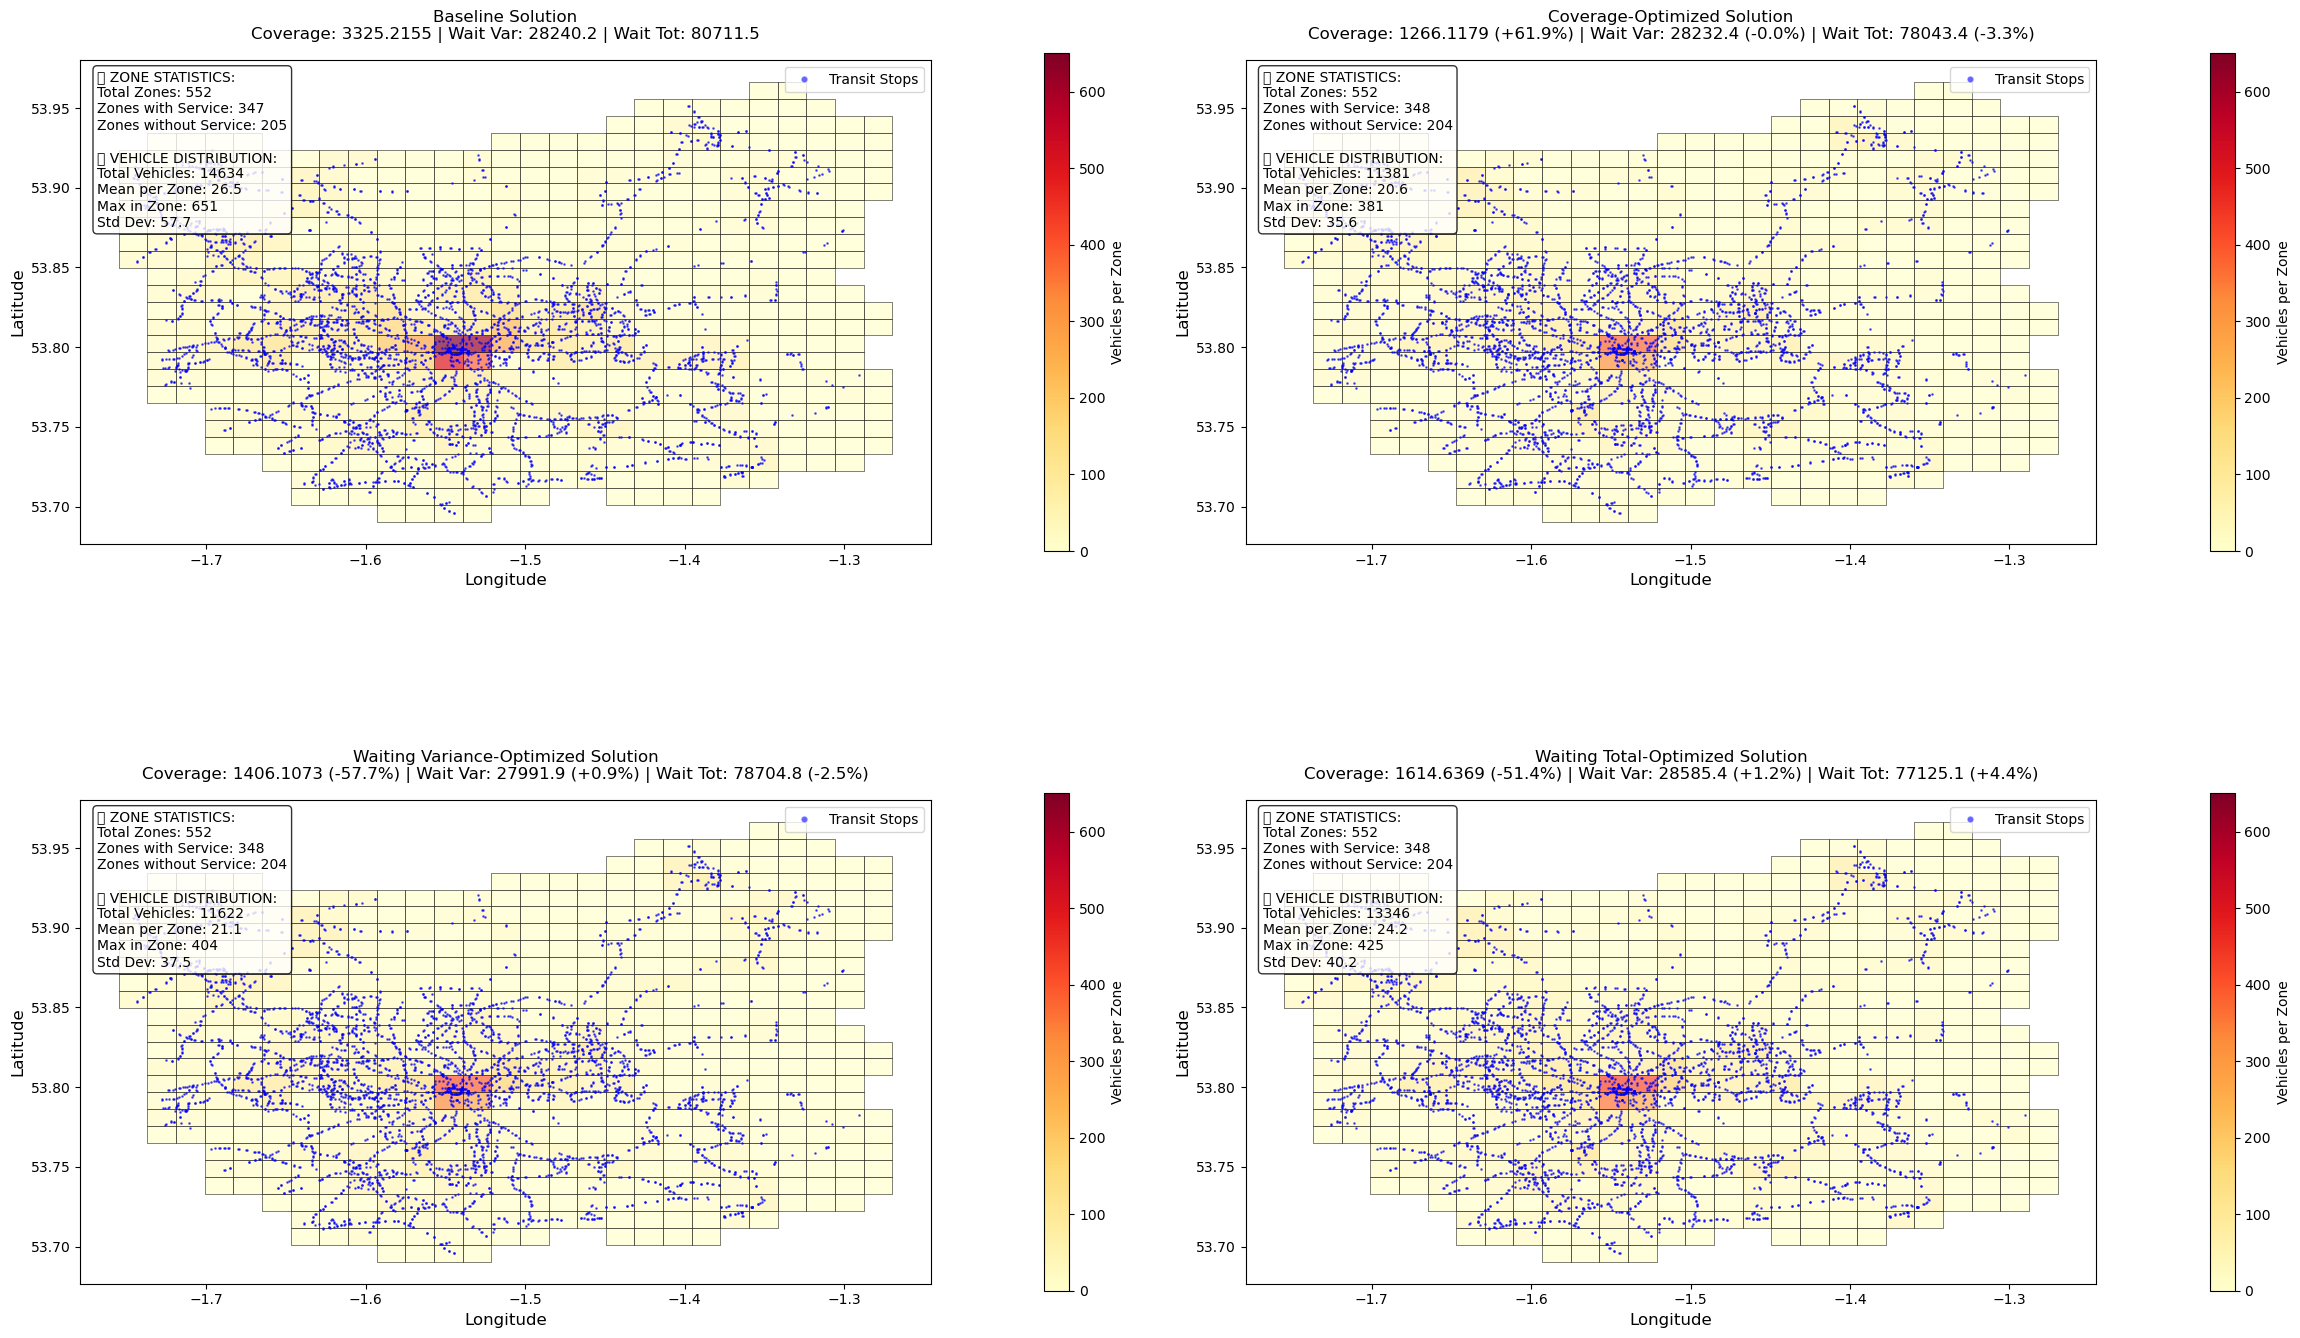


📊 SPATIAL PATTERN ANALYSIS:
   Analyzing differences in vehicle deployment patterns between solutions...
   Coverage vs Waiting Variance:
     • Coverage adds more service in 181 zones
     • Waiting Variance adds more service in 163 zones
     • Similar service in 208 zones
     • Max difference: 27.25 vehicles per zone
   Coverage vs Waiting Total:
     • Coverage adds more service in 79 zones
     • Waiting Total adds more service in 269 zones
     • Similar service in 204 zones
     • Max difference: 44.25 vehicles per zone
   Waiting Variance vs Waiting Total:
     • Waiting Variance adds more service in 89 zones
     • Waiting Total adds more service in 256 zones
     • Similar service in 207 zones
     • Max difference: 36.50 vehicles per zone

🚗 FLEET REQUIREMENTS COMPARISON:
   Comparing peak vehicle requirements for each optimized solution...
Solution                  Peak Fleet   Fleet Change   
----------------------------------------------------
Baseline                  

In [15]:
# =============================================================================
# SECTION 4: COMPREHENSIVE SPATIAL VISUALIZATION AND COMPARISON
# =============================================================================

print("\n" + "="*80)
print("🗺️ SECTION 4: COMPREHENSIVE SPATIAL VISUALIZATION AND COMPARISON")
print("="*80)

print("\n📊 SPATIAL COMPARISON SETUP:")

# STEP 1: Extract vehicle distributions from all optimized solutions
# Each solution produces a different spatial pattern of vehicle deployment
# We extract the "average" vehicles per zone (averaged across time intervals)

# Baseline: Current GTFS system as starting point
baseline_vehicles = coverage_objective.spatial_system._vehicles_per_zone(
    opt_data['initial_solution'], opt_data
)["average"]

# Coverage-optimized: Emphasizes spatial equity (even distribution)
coverage_vehicles = coverage_objective.spatial_system._vehicles_per_zone(
    result_coverage.best_solution, opt_data
)["average"]

# Waiting variance-optimized: Emphasizes temporal equity (equal waiting times)
waiting_var_vehicles = waiting_objective.spatial_system._vehicles_per_zone(
    result_waiting.best_solution, opt_data
)["average"]

# Waiting total-optimized: Emphasizes efficiency (minimize total waiting)
waiting_total_vehicles = waiting_objective_total.spatial_system._vehicles_per_zone(
    result_waiting_total.best_solution, opt_data
)["average"]

# STEP 2: Set consistent color scale for fair visual comparison
# All maps use same color range so differences are visible
vmin = 0
vmax = max(baseline_vehicles.max(), coverage_vehicles.max(), 
           waiting_var_vehicles.max(), waiting_total_vehicles.max())

print(f"   Consistent color scale: 0 to {vmax:.1f} vehicles per zone")
print(f"   Total zones: {len(baseline_vehicles)}")
print(f"   All maps show vehicle service levels (darker = more vehicles)")

# STEP 3: Create 2×2 spatial comparison grid
fig, axes = plt.subplots(2, 2, figsize=(24, 16))

# Plot 1: BASELINE SOLUTION (top-left)
# Shows current GTFS system performance across all zones
coverage_objective.spatial_system.visualize_spatial_coverage(
    solution_matrix=opt_data['initial_solution'],    # Original headway matrix
    optimization_data=opt_data,
    ax=axes[0, 0],
    show_stops=True,                                 # Overlay transit stop locations
    vmin=vmin, vmax=vmax                            # Consistent color scale
)
# Title shows performance on all three metrics for comparison
baseline_title = (f'Baseline Solution\n'
                 f'Coverage: {current_coverage_value:.4f} | '          # Spatial equity
                 f'Wait Var: {current_waiting_value:.1f} | '          # Temporal equity  
                 f'Wait Tot: {current_waiting_value_total:.1f}')      # Efficiency
axes[0, 0].set_title(baseline_title, fontsize=12, pad=15)

# Plot 2: COVERAGE-OPTIMIZED SOLUTION (top-right)  
# Shows solution that prioritizes spatial equity (even vehicle distribution)
coverage_objective.spatial_system.visualize_spatial_coverage(
    solution_matrix=result_coverage.best_solution,   # Optimized headway matrix
    optimization_data=opt_data,
    ax=axes[0, 1],
    show_stops=True,
    vmin=vmin, vmax=vmax
)
# Calculate how this solution performs on other objectives (cross-evaluation)
coverage_improvement = ((current_coverage_value - result_coverage.best_objective) / current_coverage_value * 100)
coverage_solution_waiting_var = waiting_objective.evaluate(result_coverage.best_solution)      # Cross-evaluate
coverage_solution_waiting_tot = waiting_objective_total.evaluate(result_coverage.best_solution) # Cross-evaluate
coverage_waiting_var_change = ((coverage_solution_waiting_var - current_waiting_value) / current_waiting_value * 100)
coverage_waiting_tot_change = ((coverage_solution_waiting_tot - current_waiting_value_total) / current_waiting_value_total * 100)

coverage_title = (f'Coverage-Optimized Solution\n'
                 f'Coverage: {result_coverage.best_objective:.4f} ({coverage_improvement:+.1f}%) | '
                 f'Wait Var: {coverage_solution_waiting_var:.1f} ({coverage_waiting_var_change:+.1f}%) | '
                 f'Wait Tot: {coverage_solution_waiting_tot:.1f} ({coverage_waiting_tot_change:+.1f}%)')
axes[0, 1].set_title(coverage_title, fontsize=12, pad=15)

# Plot 3: WAITING VARIANCE-OPTIMIZED SOLUTION (bottom-left)
# Shows solution that prioritizes temporal equity (equal waiting times across zones)
waiting_objective.spatial_system.visualize_spatial_coverage(
    solution_matrix=result_waiting.best_solution,
    optimization_data=opt_data,
    ax=axes[1, 0],
    show_stops=True,
    vmin=vmin, vmax=vmax
)
# Cross-evaluate this solution on other objectives
waiting_var_improvement = ((current_waiting_value - result_waiting.best_objective) / current_waiting_value * 100)
waiting_var_solution_coverage = coverage_objective.evaluate(result_waiting.best_solution)
waiting_var_solution_waiting_tot = waiting_objective_total.evaluate(result_waiting.best_solution)
waiting_var_coverage_change = ((waiting_var_solution_coverage - current_coverage_value) / current_coverage_value * 100)
waiting_var_tot_change = ((waiting_var_solution_waiting_tot - current_waiting_value_total) / current_waiting_value_total * 100)

waiting_var_title = (f'Waiting Variance-Optimized Solution\n'
                    f'Coverage: {waiting_var_solution_coverage:.4f} ({waiting_var_coverage_change:+.1f}%) | '
                    f'Wait Var: {result_waiting.best_objective:.1f} ({waiting_var_improvement:+.1f}%) | '
                    f'Wait Tot: {waiting_var_solution_waiting_tot:.1f} ({waiting_var_tot_change:+.1f}%)')
axes[1, 0].set_title(waiting_var_title, fontsize=12, pad=15)

# Plot 4: WAITING TOTAL-OPTIMIZED SOLUTION (bottom-right)
# Shows solution that prioritizes efficiency (minimize total waiting time)
waiting_objective_total.spatial_system.visualize_spatial_coverage(
    solution_matrix=result_waiting_total.best_solution,
    optimization_data=opt_data,
    ax=axes[1, 1],
    show_stops=True,
    vmin=vmin, vmax=vmax
)
# Cross-evaluate this solution on other objectives
waiting_tot_improvement = ((current_waiting_value_total - result_waiting_total.best_objective) / current_waiting_value_total * 100)
waiting_tot_solution_coverage = coverage_objective.evaluate(result_waiting_total.best_solution)
waiting_tot_solution_waiting_var = waiting_objective.evaluate(result_waiting_total.best_solution)
waiting_tot_coverage_change = ((waiting_tot_solution_coverage - current_coverage_value) / current_coverage_value * 100)
waiting_tot_var_change = ((waiting_tot_solution_waiting_var - current_waiting_value) / current_waiting_value * 100)

waiting_tot_title = (f'Waiting Total-Optimized Solution\n'
                    f'Coverage: {waiting_tot_solution_coverage:.4f} ({waiting_tot_coverage_change:+.1f}%) | '
                    f'Wait Var: {waiting_tot_solution_waiting_var:.1f} ({waiting_tot_var_change:+.1f}%) | '
                    f'Wait Tot: {result_waiting_total.best_objective:.1f} ({waiting_tot_improvement:+.1f}%)')
axes[1, 1].set_title(waiting_tot_title, fontsize=12, pad=15)

plt.tight_layout()
plt.show()

print(f"\n📊 SPATIAL PATTERN ANALYSIS:")
print("   Analyzing differences in vehicle deployment patterns between solutions...")

# STEP 4: Quantify spatial differences between solutions
# This analysis reveals how different objectives lead to different spatial strategies
solution_pairs = [
    ('coverage', coverage_vehicles, 'Coverage'),                    # Spatial equity focus
    ('waiting_var', waiting_var_vehicles, 'Waiting Variance'),     # Temporal equity focus  
    ('waiting_total', waiting_total_vehicles, 'Waiting Total')     # Efficiency focus
]

# Compare each pair of solutions to understand trade-offs
for i, (name1, vehicles1, label1) in enumerate(solution_pairs):
    for j, (name2, vehicles2, label2) in enumerate(solution_pairs[i+1:], i+1):
        # Calculate zone-by-zone differences in vehicle deployment
        vehicle_difference = vehicles1 - vehicles2  # Positive = solution1 has more vehicles
        diff_max = max(abs(vehicle_difference.min()), abs(vehicle_difference.max()))
        
        if diff_max > 0.01:  # Only report meaningful differences
            # Count zones where solutions differ significantly
            zones_sol1_favors = np.sum(vehicle_difference > 0.1)     # Solution1 adds more service
            zones_sol2_favors = np.sum(vehicle_difference < -0.1)    # Solution2 adds more service
            zones_similar = np.sum(np.abs(vehicle_difference) <= 0.1) # Similar service levels
            
            print(f"   {label1} vs {label2}:")
            print(f"     • {label1} adds more service in {zones_sol1_favors} zones")
            print(f"     • {label2} adds more service in {zones_sol2_favors} zones") 
            print(f"     • Similar service in {zones_similar} zones")
            print(f"     • Max difference: {diff_max:.2f} vehicles per zone")
        else:
            print(f"   {label1} vs {label2}: Solutions are spatially very similar")

# STEP 5: Fleet requirements comparison
# Check if solutions require different numbers of vehicles to operate
print(f"\n🚗 FLEET REQUIREMENTS COMPARISON:")
print("   Comparing peak vehicle requirements for each optimized solution...")

from transit_opt.optimisation.utils import calculate_fleet_requirements

fleet_analysis = opt_data['constraints']['fleet_analysis']
operational_buffer = fleet_analysis.get('operational_buffer', 1.15)  # 15% operational buffer

# Calculate fleet needs for baseline system
baseline_fleet = calculate_fleet_requirements(
    headways_matrix=opt_data['initial_solution'],    # Original headway decisions
    round_trip_times=opt_data['routes']['round_trip_times'],
    operational_buffer=operational_buffer,
    no_service_threshold=480.0,
    allowed_headways=opt_data['allowed_headways'],
    no_service_index=opt_data.get('no_service_index')
)

# Calculate fleet needs for each optimized solution
coverage_fleet = calculate_fleet_requirements(
    headways_matrix=result_coverage.best_solution,   # Coverage-optimized headways
    round_trip_times=opt_data['routes']['round_trip_times'],
    operational_buffer=operational_buffer,
    no_service_threshold=480.0,
    allowed_headways=opt_data['allowed_headways'],
    no_service_index=opt_data.get('no_service_index')
)

waiting_var_fleet = calculate_fleet_requirements(
    headways_matrix=result_waiting.best_solution,    # Variance-optimized headways
    round_trip_times=opt_data['routes']['round_trip_times'],
    operational_buffer=operational_buffer,
    no_service_threshold=480.0,
    allowed_headways=opt_data['allowed_headways'],
    no_service_index=opt_data.get('no_service_index')
)

waiting_tot_fleet = calculate_fleet_requirements(
    headways_matrix=result_waiting_total.best_solution,  # Total-optimized headways
    round_trip_times=opt_data['routes']['round_trip_times'],
    operational_buffer=operational_buffer,
    no_service_threshold=480.0,
    allowed_headways=opt_data['allowed_headways'],
    no_service_index=opt_data.get('no_service_index')
)

# Display fleet comparison table
print(f"{'Solution':<25} {'Peak Fleet':<12} {'Fleet Change':<15}")
print("-" * 52)
print(f"{'Baseline':<25} {baseline_fleet['total_peak_fleet']:<12} {'0.0%':<15}")

# Calculate percentage changes from baseline
coverage_fleet_change = ((coverage_fleet['total_peak_fleet'] - baseline_fleet['total_peak_fleet']) / baseline_fleet['total_peak_fleet'] * 100)
print(f"{'Coverage-Optimized':<25} {coverage_fleet['total_peak_fleet']:<12} {coverage_fleet_change:+.1f}%{'':<10}")

waiting_var_fleet_change = ((waiting_var_fleet['total_peak_fleet'] - baseline_fleet['total_peak_fleet']) / baseline_fleet['total_peak_fleet'] * 100)
print(f"{'Waiting Var-Optimized':<25} {waiting_var_fleet['total_peak_fleet']:<12} {waiting_var_fleet_change:+.1f}%{'':<10}")

waiting_tot_fleet_change = ((waiting_tot_fleet['total_peak_fleet'] - baseline_fleet['total_peak_fleet']) / baseline_fleet['total_peak_fleet'] * 100)
print(f"{'Waiting Tot-Optimized':<25} {waiting_tot_fleet['total_peak_fleet']:<12} {waiting_tot_fleet_change:+.1f}%{'':<10}")

# INTERPRETATION:
# - Fleet changes show operational impact of different optimization strategies
# - Negative changes = more efficient (fewer vehicles needed)
# - Positive changes = more service (more vehicles needed, but within constraints)
# - Large differences suggest fundamentally different deployment strategies